### look back values for btc_close price
look_back_values = [1, 2, 5, 10, 20]

In [79]:
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skorch import NeuralNetRegressor
from sklearn.preprocessing import MinMaxScaler
from skopt.space import Real, Categorical, Integer
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator

device = torch.device("cpu")

In [80]:
train_residuals_df = pd.read_csv("../data/final/train_residuals_df.csv", parse_dates=["Date"], index_col="Date")
test_residuals_df = pd.read_csv("../data/final/test_residuals_df.csv", parse_dates=["Date"], index_col="Date")

train_residual = train_residuals_df["Residuals"]
test_residual = test_residuals_df["Residuals"]

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.values.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.values.reshape(-1, 1))

# save scaler
joblib.dump(scaler, "../models/residual_scaler.pkl")

['../models/residual_scaler.pkl']

In [82]:
train_residual_scaled = train_residual_scaled.astype(np.float32)
test_residual_scaled = test_residual_scaled.astype(np.float32)

In [83]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.position_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_dim))

    def forward(self, x):
        return self.position_encoding[:, :x.size(1), :]

In [84]:
import torch
import torch.nn as nn

class Seq2SeqTemporalFusionTransformer(nn.Module):
    def __init__(self, look_back, num_heads, hidden_dim, feed_forward_dim, dropout_rate,
                 num_layers=1, activation="relu", input_feature_dim=1, n_steps_ahead=1):
        super(Seq2SeqTemporalFusionTransformer, self).__init__()
        self.look_back = look_back
        self.n_steps_ahead = n_steps_ahead
        self.hidden_dim = hidden_dim

        # Input projection
        self.input_projection = nn.Linear(input_feature_dim, hidden_dim)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(max_len=look_back + n_steps_ahead, hidden_dim=hidden_dim)

        # Define the activation function dynamically
        if activation == "relu":
            self.activation_fn = nn.ReLU()
        elif activation == "elu":
            self.activation_fn = nn.ELU(alpha=1.0)
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.ModuleDict({
                "multi_head_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "layer_norm1": nn.LayerNorm(hidden_dim),
                "feed_forward": nn.Sequential(
                    nn.Linear(hidden_dim, feed_forward_dim),
                    self.activation_fn,
                    nn.Dropout(dropout_rate),
                    nn.Linear(feed_forward_dim, hidden_dim)
                ),
                "layer_norm2": nn.LayerNorm(hidden_dim)
            })
            for _ in range(num_layers)
        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.ModuleDict({
                "self_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "cross_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "layer_norm1": nn.LayerNorm(hidden_dim),
                "feed_forward": nn.Sequential(
                    nn.Linear(hidden_dim, feed_forward_dim),
                    self.activation_fn,
                    nn.Dropout(dropout_rate),
                    nn.Linear(feed_forward_dim, hidden_dim)
                ),
                "layer_norm2": nn.LayerNorm(hidden_dim)
            })
            for _ in range(num_layers)
        ])

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, input_feature_dim)

    def forward(self, src, tgt):
        # Input projection
        src = self.input_projection(src)  # Shape: (batch_size, look_back, hidden_dim)
        tgt = self.input_projection(tgt)  # Shape: (batch_size, n_steps_ahead, hidden_dim)

        # Add positional encoding
        src = src + self.positional_encoding(src)
        tgt = tgt + self.positional_encoding(tgt)

        # Encoder
        for layer in self.encoder_layers:
            # Self-attention
            attn_output, _ = layer["multi_head_attention"](src, src, src)
            src = layer["layer_norm1"](src + attn_output)

            # Feed-forward network
            ff_output = layer["feed_forward"](src)
            src = layer["layer_norm2"](src + ff_output)

        # Decoder
        for layer in self.decoder_layers:
            # Self-attention
            self_attn_output, _ = layer["self_attention"](tgt, tgt, tgt)
            tgt = layer["layer_norm1"](tgt + self_attn_output)

            # Cross-attention (attends to encoder output)
            cross_attn_output, _ = layer["cross_attention"](tgt, src, src)
            tgt = layer["layer_norm1"](tgt + cross_attn_output)

            # Feed-forward network
            ff_output = layer["feed_forward"](tgt)
            tgt = layer["layer_norm2"](tgt + ff_output)

        # Output projection
        outputs = self.output_layer(tgt)  # Shape: (batch_size, n_steps_ahead, input_feature_dim)
        return outputs

### Hyperparameters Tuning using Bayes Optimization

In [85]:
class Seq2SeqTemporalFusionTransformerWrapper(nn.Module):
    def __init__(self, look_back, num_heads, head_dim, feed_forward_dim, dropout_rate, num_layers, activation, n_steps_ahead):
        super(Seq2SeqTemporalFusionTransformerWrapper, self).__init__()
        self.look_back = look_back
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers
        self.activation = activation
        self.n_steps_ahead = n_steps_ahead
        
        # Initialize the Seq2Seq TFT model
        self.model = Seq2SeqTemporalFusionTransformer(
            look_back=look_back,
            num_heads=num_heads,
            hidden_dim=num_heads * head_dim,
            feed_forward_dim=feed_forward_dim,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            activation=activation,
            input_feature_dim=1,  # Assuming univariate time series
            n_steps_ahead=n_steps_ahead
        )

    def forward(self, src, tgt=None):
        if src.dim() == 2:
            src = src.unsqueeze(-1)  # Add feature dimension if missing
        
        # If tgt is not provided (during inference), initialize it with zeros
        if tgt is None:
            tgt = torch.zeros(src.size(0), self.n_steps_ahead, 1).to(src.device)  # Shape: (batch_size, n_steps_ahead, 1)
        
        # Ensure tgt is 3D: (batch_size, n_steps_ahead, input_feature_dim)
        if tgt.dim() == 2:
            tgt = tgt.unsqueeze(-1)  # Add feature dimension if missing
        
        # Forward pass through the model
        outputs = self.model(src, tgt)  # Shape: (batch_size, n_steps_ahead, 1)
        
        # Reshape output to (batch_size, n_steps_ahead)
        outputs = outputs.squeeze(-1)  # Remove the last dimension if it's 1
        
        return outputs
    
    def state_dict(self, *args, **kwargs):
        """
        Override to save only the state_dict of the underlying model.
        """
        return {
            'model_state_dict': self.model.state_dict(),
            'hyperparameters': {
                'look_back': self.look_back,
                'num_heads': self.num_heads,
                'head_dim': self.head_dim,
                'feed_forward_dim': self.feed_forward_dim,
                'dropout_rate': self.dropout_rate,
                'num_layers': self.num_layers,
                'activation': self.activation,
                'n_steps_ahead': self.n_steps_ahead
            }
        }

    def load_state_dict(self, state_dict, strict=True):
        """
        Override to load the state_dict into the underlying model.
        """
        self.model.load_state_dict(state_dict['model_state_dict'], strict=strict)

    def predict(self, X):
        """
        Predict on given input data (e.g., X_test or future data).
        
        Parameters:
        - X (np.ndarray or torch.Tensor): Input data of shape (batch_size, look_back).
        
        Returns:
        - np.ndarray: Predicted values of shape (batch_size, n_steps_ahead).
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        if X.dim() == 2:
            X = X.unsqueeze(-1)  # Add feature dimension if missing

        # Set the model to evaluation mode
        self.eval()

        with torch.no_grad():
            predictions = self.forward(X)  # Forward pass for prediction

        return predictions.numpy()

In [86]:
# Define search space for BayesSearchCV
search_space = {
    "num_heads": Categorical([2, 4, 8]),  
    "head_dim": Categorical([8, 16, 32]),  
    "feed_forward_dim": Categorical([128, 256, 512, 1024]),  
    "dropout_rate": Real(0.1, 0.4),  
    "lr": Real(5e-5, 5e-3, prior="log-uniform"), 
    "batch_size": Categorical([16, 32, 64]), 
    "num_layers": Categorical([1, 2, 3, 4]),
    "activation": Categorical(["relu", "elu"]),
}

In [87]:
def create_multi_step_dataset(data, look_back, n_steps_ahead=1):
    X, y = [], []
    for i in range(len(data) - look_back - n_steps_ahead + 1):
        X.append(data[i:i + look_back, 0])  # Input sequence
        y.append(data[i + look_back:i + look_back + n_steps_ahead, 0])  # Multi-step target
    return np.array(X), np.array(y)

# Prepare training and testing datasets
look_back = 7
n_steps_ahead = 3

# Create train and test datasets
X_train, y_train = create_multi_step_dataset(train_residual_scaled, look_back, n_steps_ahead)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = create_multi_step_dataset(test_residual_scaled, look_back, n_steps_ahead)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(722, 7, 1) (722, 3) (722, 7, 1) (722, 3)


In [88]:
from sklearn.base import BaseEstimator
import torch
import torch.nn as nn

class TFTEstimator(BaseEstimator):
    def __init__(self, look_back=7, num_heads=4, head_dim=16, feed_forward_dim=128,
                 dropout_rate=0.1, lr=0.001, batch_size=32, num_layers=2, activation="relu", n_steps_ahead=3):
        self.look_back = look_back
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.activation = activation
        self.n_steps_ahead = n_steps_ahead

        # Store model hyperparameters
        self.model_params = {
            "look_back": look_back,
            "num_heads": num_heads,
            "head_dim": head_dim,
            "feed_forward_dim": feed_forward_dim,
            "dropout_rate": dropout_rate,
            "num_layers": num_layers,
            "activation": activation,
            "n_steps_ahead": n_steps_ahead
        }

        # # Store training hyperparameters
        # self.training_params = {
        #     "lr": lr,
        #     "batch_size": batch_size,
        # }
        
        # Initialize the Seq2Seq TFT model
        self.model = Seq2SeqTemporalFusionTransformerWrapper(**self.model_params)

    def fit(self, X, y):
        # Convert inputs to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (batch_size, look_back, 1)
        y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (batch_size, n_steps_ahead, 1)
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Training loop
        for epoch in range(10):  # Example: 10 epochs
            optimizer.zero_grad()
            outputs = self.model(X_tensor, y_tensor)  # Forward pass with src and tgt
            loss = criterion(outputs, y_tensor)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
        return self

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (batch_size, look_back, 1)
            predictions = self.model(X_tensor)  # Forward pass with src only (tgt is initialized internally)
        return predictions.numpy()

In [89]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.model_selection import BaseCrossValidator
# Define ExpandingWindowSplitter
expanding_splitter = ExpandingWindowSplitter(initial_window=365, step_length=30, fh=[1, 7])

# Custom Wrapper for ExpandingWindowSplitter
class SKTimeToSKLearnCV(BaseCrossValidator):
    def __init__(self, sktime_splitter, y):
        self.sktime_splitter = sktime_splitter
        self.y = y

    def split(self, X, y=None, groups=None):
        for train_idx, test_idx in self.sktime_splitter.split(self.y):
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.sktime_splitter.get_n_splits(self.y)

In [90]:
# Wrap the model with BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=TFTEstimator(
        look_back=look_back,
        n_steps_ahead=n_steps_ahead
    ),
    search_spaces=search_space,
    n_iter=200,
    # cv=TimeSeriesSplit(n_splits=5),
    cv=SKTimeToSKLearnCV(expanding_splitter, y_train),
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
    # random_state=42
)

# Fit the search
bayes_search.fit(X_train, y_train)

Fitting 12 folds for each of 1 candidates, totalling 12 fits
Epoch 1, Loss: 0.06588783860206604
Epoch 1, Loss: 0.8594958782196045
Epoch 1, Loss: 0.16960303485393524
Epoch 1, Loss: 0.24192939698696136
Epoch 1, Loss: 0.043014105409383774
Epoch 1, Loss: 0.9541491270065308
Epoch 1, Loss: 0.4221175014972687
Epoch 1, Loss: 0.04805696755647659
Epoch 1, Loss: 0.3923094570636749
Epoch 2, Loss: 0.052915167063474655
Epoch 1, Loss: 0.11373130232095718
Epoch 1, Loss: 0.11613036692142487
Epoch 1, Loss: 0.407204806804657
Epoch 2, Loss: 0.7076079845428467
Epoch 2, Loss: 0.11117853969335556
Epoch 2, Loss: 0.024861186742782593
Epoch 3, Loss: 0.05006519332528114
Epoch 2, Loss: 0.017203669995069504
Epoch 2, Loss: 0.2900976240634918
Epoch 2, Loss: 0.16548898816108704
Epoch 2, Loss: 0.31902244687080383
Epoch 2, Loss: 0.7942622303962708
Epoch 2, Loss: 0.09521850943565369
Epoch 2, Loss: 0.06548501551151276
Epoch 3, Loss: 0.076499804854393
Epoch 4, Loss: 0.046863261610269547
Epoch 3, Loss: 0.5770037174224854
E

BayesSearchCV(cv=SKTimeToSKLearnCV(sktime_splitter=ExpandingWindowSplitter(fh=[1, 7], initial_window=365, step_length=30),
         y=array([[0.07575, 0.08068, 0.09333],
       [0.08068, 0.09333, 0.13503],
       ...,
       [0.22176, 0.21108, 0.19289],
       [0.21108, 0.19289, 0.17323]], dtype=float32)),
              estimator=TFTEstimator(), n_iter=200, n_jobs=-1,
              scoring='neg_mean_absolute_error',
              search_spaces={'a...
                             'dropout_rate': Real(low=0.1, high=0.4, prior='uniform', transform='normalize'),
                             'feed_forward_dim': Categorical(categories=(128, 256, 512, 1024), prior=None),
                             'head_dim': Categorical(categories=(8, 16, 32), prior=None),
                             'lr': Real(low=5e-05, high=0.005, prior='log-uniform', transform='normalize'),
                             'num_heads': Categorical(categories=(2, 4, 8), prior=None),
                             'num_layers': Categorical(categories=(1, 2, 3, 4), prior=None)},
              verbose=2)

In [91]:
# import torch
# import json
# import joblib

# # Save the best hyperparameters
# with open('../models/lookback7/best_tft_hyperparams.json', 'w') as f:
#     json.dump(bayes_search.best_estimator_.model_params, f)
#     # json.dump(bayes_search.best_params_, f)

# # Save the state_dict of the best model
# torch.save(bayes_search.best_estimator_.model.state_dict(), '../models/lookback7/best_tft_model.pth')

# # Save the BayesSearchCV object (optional)
# joblib.dump(bayes_search, '../models/lookback7/best_bayes_search.pkl')

# # Save additional metadata (e.g., best score)
# best_score = -bayes_search.best_score_
# with open('../models/lookback7/best_tft_score.txt', 'w') as f:
#     f.write(str(best_score))

# # with open('../models/lookback7/best_tft_hyperparams.json', 'r') as f:
# #     model_params = json.load(f)

# # exclude_keys = ['batch_size', 'lr']  # List of keys to exclude
# # model_params = {k: v for k, v in model_params.items() if k not in exclude_keys}

# # # Add new parameters
# # model_params.update({'look_back': 7, 'n_steps_ahead': 3})

# # model_params

# # Load the saved hyperparameters
# with open('../models/lookback7/best_tft_hyperparams.json', 'r') as f:
#     model_params = json.load(f)

# # Reinitialize the model using the saved hyperparameters
# best_model = Seq2SeqTemporalFusionTransformerWrapper(**model_params)

# # Load the saved state_dict into the model
# state_dict = torch.load('../models/lookback7/best_tft_model.pth', weights_only=True)
# best_model.load_state_dict(state_dict)

# # Set the model to evaluation mode
# best_model.eval()

# print("Best model loaded successfully.")


In [92]:
import joblib

# Save the BayesSearchCV object
joblib.dump(bayes_search, "../models/lookback7/bayes_search_tft_seq2seq.pkl")
print("Model saved successfully.")

Model saved successfully.


In [93]:
# Load the BayesSearchCV object
best_model = joblib.load("../models/lookback7/bayes_search_tft_seq2seq.pkl")
print("Model loaded successfully.")


Model loaded successfully.


In [94]:
# Make predictions
y_pred = best_model.predict(X_test)

# Inverse transform the predictions
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Evaluate the predictions
mse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# save metrics as dataframe and save to csv
metrics = pd.DataFrame({'MSE': [mse], 'MAE': [mae], 'MAPE': [mape]})
metrics.to_csv('../results/metrics/lookback7/tft_seq2seq_metrics.csv', index=False)

# Save the predictions as .npy file
np.save('../results/predictions/test/lookback7/tft_seq2seq_predictions.npy', y_pred_inverse)

Mean Squared Error (MSE): 0.9505518078804016
Mean Absolute Error (MAE): 0.8998581767082214
Mean Absolute Percentage Error (MAPE): 5.73951530456543


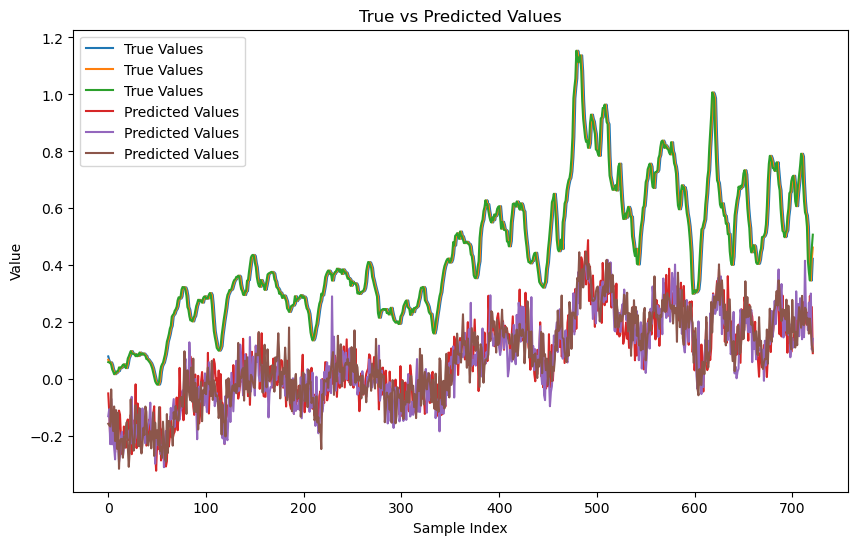

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.show()

In [103]:
import torch
import numpy as np

# Define the number of future days to predict
future_days = 300

# Get the most recent data
recent_data = X_test[-1].reshape(1, -1, 1)  # Shape: (1, look_back, 1)
recent_data = torch.tensor(recent_data, dtype=torch.float32)

# Initialize a list to store all predictions
predictions = []  # This will store predictions for all future days

# Make predictions for future_days
for _ in range(future_days):
    # Predict the next step
    prediction = best_model.predict(recent_data)  # Shape: (1, n_steps_ahead)
    
    # Convert prediction to a PyTorch tensor
    prediction_tensor = torch.tensor(prediction, dtype=torch.float32)
    
    # Append the prediction to the predictions list
    predictions.append(prediction_tensor.squeeze().tolist())  # Shape: (n_steps_ahead,)
    
    # Update recent_data for the next iteration
    # Use the first predicted value to update recent_data
    recent_data = torch.cat([recent_data[:, 1:, :], prediction_tensor[:, 0].unsqueeze(1).unsqueeze(-1)], dim=1)

# Convert predictions list to a numpy array
predictions = np.array(predictions)  # Shape: (future_days, n_steps_ahead)

# Inverse transform the predictions using the scaler
predictions_inverse = scaler.inverse_transform(predictions)  # Shape: (future_days, n_steps_ahead)

# Split the inverse-transformed predictions into separate arrays
predictions_1_inverse = predictions_inverse[:, 0]  # First predicted value
predictions_2_inverse = predictions_inverse[:, 1]  # Second predicted value
predictions_3_inverse = predictions_inverse[:, 2]  # Third predicted value

/var/folders/pf/4hxrldrx2g7g5x19dwlvk36w0000gn/T/ipykernel_60058/3212807902.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (batch_size, look_back, 1)


In [104]:
import importlib.util
import sys

module_name = "arima_garch_forecast"
module_path = "/Users/binnu/Library/CloudStorage/OneDrive-student.vgu.edu.vn/VGU/Current Program/Project/Bitcoin Prediction/src/utils/prediction.py"

# Load the module
spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

In [105]:
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_pca_df = pd.read_csv("../data/final/val_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_exog = val_pca_df.drop(columns=["btc_close"])
test_exog = test_pca_df.drop(columns=["btc_close"])
# concat val and test exog
exog = pd.concat([val_exog, test_exog])

arimax_garch_future = module.arima_garch_forecast(exog, '../models', future_days)

In [106]:
last_date = test_residuals_df.index[-1]

# Undo log-transform (ARIMA-GARCH predictions + TFT predictions)
final_predictions = []

for i in range(3):
    final_predictions.append(np.exp(predictions_inverse[:, i] + arimax_garch_future) - 1)

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(final_predictions[0]))

# Create the DataFrame of future predictions
df_predictions =  pd.DataFrame(final_predictions).T  # Transpose to make each array a column

# Rename the index to 'Day' for clarity
df_predictions.index = future_dates

df_predictions.columns = ['Forecast Price (Case 1)', 'Forecast Price (Case 2)', 'Forecast Price (Case 3)']

In [107]:
test_actual_values = np.exp(test_pca_df["btc_close"]) - 1
test_arima_garch_pred = test_residuals_df["SARIMA-GARCH Prediction"]
test_arima_garch_pred_org = np.exp(test_arima_garch_pred) - 1
# load np.save('../results/predictions/test/lookback7/tft_seq2seq_predictions.npy', y_pred_inverse)
test_tft_pred = np.load('../results/predictions/test/lookback7/tft_seq2seq_predictions.npy')

test_tft_pred_list = []
combined_test_pred_list = []
combined_test_pred_org_list = []

for i in range(3):
    test_tft_pred_list.append(test_tft_pred[:, i])
    combined_test_pred = test_arima_garch_pred[look_back+2:] + test_tft_pred_list[i]
    combined_test_pred_list.append(combined_test_pred)
    combined_test_pred_org_list.append(np.exp(combined_test_pred) - 1)

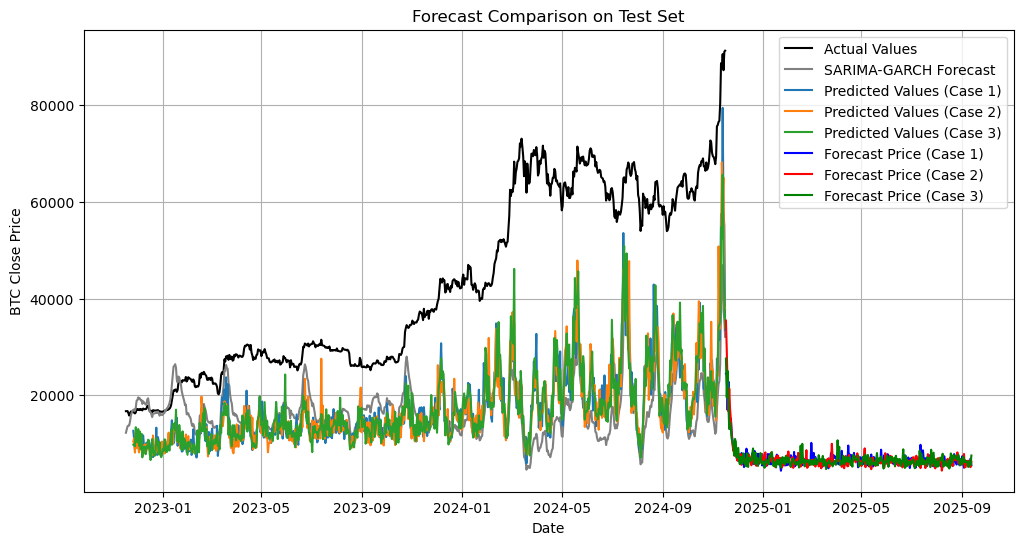

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(test_pca_df.index, test_actual_values, label="Actual Values", color="black")
plt.plot(test_pca_df.index,test_arima_garch_pred_org, label="SARIMA-GARCH Forecast", color="grey")
for i in range(3):
    plt.plot(combined_test_pred_org_list[i], label=f"Predicted Values (Case {i + 1})")
plt.plot(df_predictions.index, df_predictions["Forecast Price (Case 1)"], label="Forecast Price (Case 1)", color="blue")
plt.plot(df_predictions.index, df_predictions["Forecast Price (Case 2)"], label="Forecast Price (Case 2)", color="red")
plt.plot(df_predictions.index, df_predictions["Forecast Price (Case 3)"], label="Forecast Price (Case 3)", color="green")

plt.title("Forecast Comparison on Test Set")
plt.xlabel("Date")
plt.ylabel("BTC Close Price")
plt.legend()
plt.grid()
# plt.savefig("../results/images/test/merge.png")
plt.show()
plt.close()

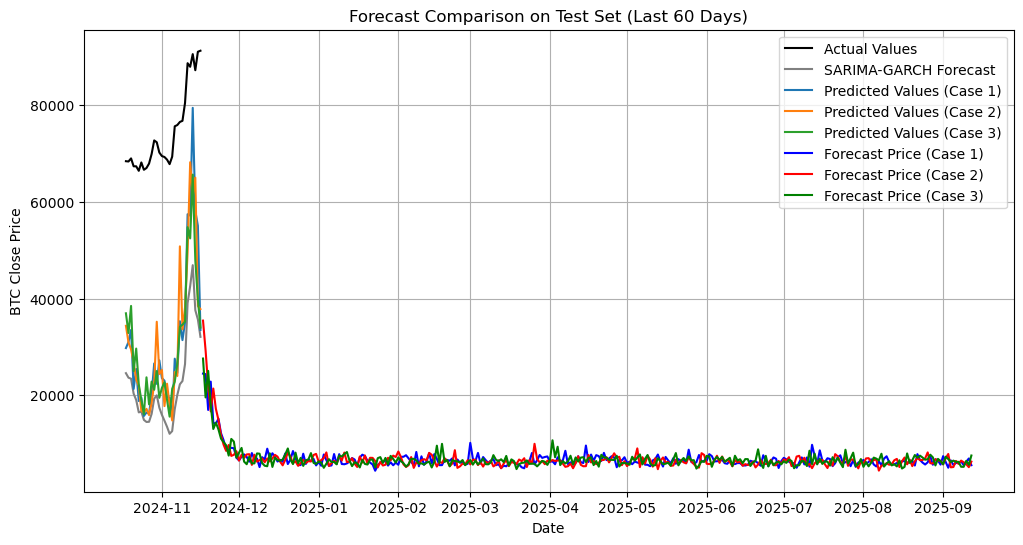

In [109]:
import matplotlib.pyplot as plt

# Slice the last 60 days of data
last_60_days = slice(-30, None)  # Slice to get the last 60 elements

plt.figure(figsize=(12, 6))

# Plot actual values (last 60 days)
plt.plot(test_pca_df.index[last_60_days], test_actual_values[last_60_days], label="Actual Values", color="black")

# Plot SARIMA-GARCH forecast (last 60 days)
plt.plot(test_pca_df.index[last_60_days], test_arima_garch_pred_org[last_60_days], label="SARIMA-GARCH Forecast", color="grey")

# Plot predicted values for each case (last 60 days)
for i in range(3):
    plt.plot(test_pca_df.index[last_60_days], combined_test_pred_org_list[i][last_60_days], label=f"Predicted Values (Case {i + 1})")

# Plot forecast prices for each case (last 60 days)
plt.plot(df_predictions.index, df_predictions["Forecast Price (Case 1)"], label="Forecast Price (Case 1)", color="blue")
plt.plot(df_predictions.index, df_predictions["Forecast Price (Case 2)"], label="Forecast Price (Case 2)", color="red")
plt.plot(df_predictions.index, df_predictions["Forecast Price (Case 3)"], label="Forecast Price (Case 3)", color="green")

# Add plot details
plt.title("Forecast Comparison on Test Set (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("BTC Close Price")
plt.legend()
plt.grid()

# Save or display the plot
# plt.savefig("../results/images/test/merge_last_60_days.png")
plt.show()
plt.close()